
# Dog breed classification 

CNN based on [lesson 2](http://course.fast.ai/lessons/lesson2.html) of the deep learning fast.ai course, with data from the Kaggle Competition [dog-breed-identification](https://www.kaggle.com/c/dog-breed-identification).

This excercise follows the lesson's steps to train a world class classification model:

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
# See http://forums.fast.ai/t/torch-cuda-is-available-returns-false/16721/8
# And https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

`PATH` is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at `224` for now.

In [6]:
# ! dir ..\..\..\Github\data\dog-breed-identification

In [7]:
PATH = "data/dog-breed-identification/"

## Initial Exploration

In [8]:
# os.listdir(PATH)
# ! ls {PATH}
! dir {PATH}

labels.csv	   sample_submission.csv      test.zip	train.zip
labels.csv.zip	   sample_submission.csv.zip  tmp
sample_labels.csv  test			      train


In [9]:
os.listdir(f'{PATH}train')[:5]

['3f06362327d11ca13c01a19182911927.jpg',
 '28324516db1ad19c3b33c1b6ad397774.jpg',
 '62b930bc746b25a1a68518194c0ef059.jpg',
 '82cd7074fe9b46b58a0ef2b74457026b.jpg',
 '369f1231c318aafcdcb56a0cdd63b5f0.jpg']

In [10]:
labels_df = pd.read_csv(PATH + 'labels.csv')
print('There are', len(labels_df), 'training observations, and',
      len(os.listdir(f'{PATH}test')), 'test observations.')
labels_df.sample(5)

There are 10222 training observations, and 10357 test observations.


,id,breed
7236,b54c71c47f3d46a3bf72fbd9301de6fa,komondor
1645,28bdfc1f5bb2c5e4794287b4c31cdf58,leonberg
7536,bcf1184ebdd1766a71ca793e5fa03e44,sussex_spaniel
9905,f8d6ec246da32576653776342d52cb69,dandie_dinmont
1377,21dfeebc515160a484d64eb9bb12bb93,bernese_mountain_dog


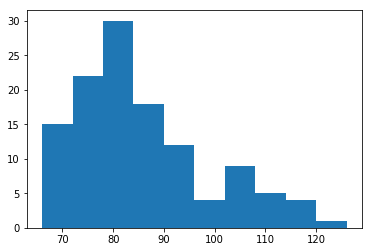

In [11]:
plt.hist(labels_df.pivot_table(index='breed', aggfunc=len).values);

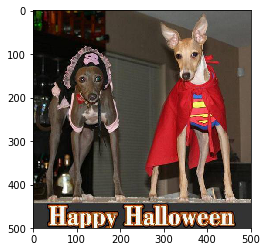

In [12]:
img = plt.imread(PATH + 'train/' + labels_df.sample(1)['id'].values[0] + '.jpg')
plt.imshow(img)

### Sample subset of images (for cpu only)

In [13]:
frac = 0.5
sample_labels_df = labels_df.sample(frac=frac).set_index('id')
sample_labels_df.to_csv(PATH + 'sample_labels.csv')

In [14]:
print('Sample:', len(sample_labels_df), ' out of', len(labels_df), 'observations.')
sample_labels_df.head()

Sample: 5111  out of 10222 observations.


,breed
id,
04cce0cd53c6f01d242a49e43de513a1,clumber
60589f1c3265c6d79fe0c6ba12009285,staffordshire_bullterrier
a2702282275212144b1683a434651d7f,affenpinscher
29975437f5b41ee4e061d83253f12d74,dandie_dinmont
6001fc9133e426ecf5250b50414534f9,entlebucher


# Model

> If the original images do not correspond to this size, thei are center cropped. For computational GPU reasons, the cropped images must be squared."

In [15]:
# Image size to feed into the model.  
sz = 224

arch = resnext101_64  # resnet34  # Model architecture.
bs = 64  # Batch size


n = len(sample_labels_df)  # len(list(open(PATH + 'labels.csv'))) - 1
val_idxs = get_cv_idxs(n, val_pct=0.2)

In [16]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=PATH + 'sample_labels.csv',
                                    test_name='test', suffix='.jpg', val_idxs=val_idxs, tfms=tfms, bs=bs)

In [17]:
fn = PATH + data.trn_ds.fnames[100]; fn

'data/dog-breed-identification/train/0450c3899b7ca7cac31406a52c7bc74e.jpg'

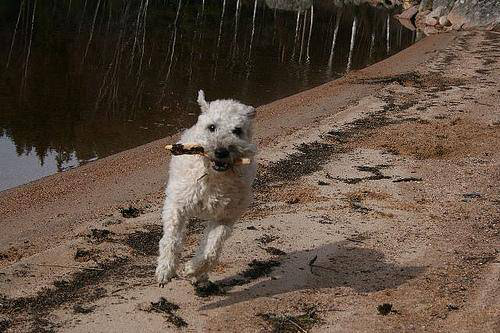

In [18]:
img = PIL.Image.open(fn); img

In [19]:
img.size

(500, 333)

In [20]:
sizes_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*sizes_d.values()))
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

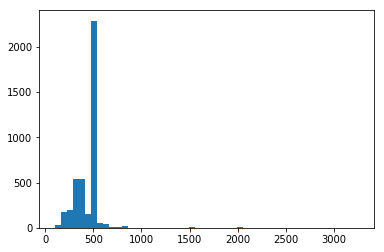

In [21]:
plt.hist(row_sz, bins = 50);  # semi-colon for not printing the bins of the histogram.

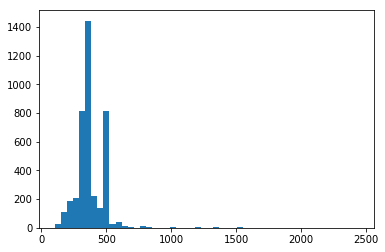

In [22]:
plt.hist(col_sz, bins = 50);

## 1. Precompute

* `precomute = True` ensures that the activations of all the frozen layers in the model are computed only once.  Afterwards, they serve as input to the last (unfrozen) layers of the model for gradient descent, speeding up computation. 
* `precompute = False` enables the recalculation of the frozen layers' activations and, thus, allows data augmentation.  However, only the weights from the unfrozen layers are being updated.
* `learn.unfreeze()` unfreezes all the layers of the model for further calibration.

The following function helps iterate faster with the model.  It receives the image's size (`sz`) and the batch size (`bs`).

1. Start with small sizes (eg. 64) for fast computing at the beginning.  Then increase the size.
1. If one runs out of memory, first **restart the kernel**, then decrease the batch size.


In [23]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=PATH + 'sample_labels.csv',
                                        test_name='test', suffix='.jpg', val_idxs=val_idxs, tfms=tfms, bs=bs)
    return data if sz > 300 else data.resize(340, 'tmp')

In [26]:
sz = 224
bs = 64
data = get_data(sz, bs)

In [27]:
# See http://forums.fast.ai/t/dog-breed-challenge-precompute-error/10988/8
# If No such file... error: ~/data/dog-breed-identification$ rm -r tmp
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 162/162 [01:41<00:00,  1.59it/s]


In [ ]:
# learn.save('pretrained_128')
learn.save('pretrained_224')

In [ ]:
# learn.load('pretrained_128')
learn.load('pretrained_224')

epoch      trn_loss   val_loss   accuracy                 
    0      11.538877  1915.437853 0.113503  



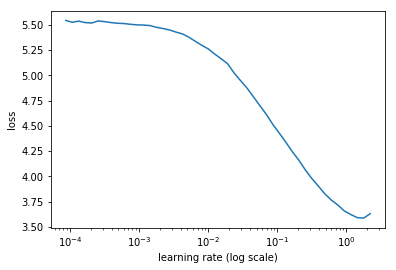

In [28]:
lrf = learn.lr_find()
# learn.sched.plot_lr()
learn.sched.plot()

In [29]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                 
    0      1.629572   0.899092   0.731898  
    1      0.916981   0.799594   0.761252                  
    2      0.60471    0.81754    0.767123                  
    3      0.436009   0.8465     0.761252                  
    4      0.316294   0.853624   0.765166                  



[array([0.85362]), 0.7651663391090886]

> The difference between `trn_loss` and `val_loss` indicates **overfitting**.  Maybe with dropout (`ps` parameter in `ConvLearner.pretrained`) or another form of regularization.

In [30]:
# ps: dropout parameter
learn = ConvLearner.pretrained(arch, data, precompute=True, ps = 0.75)

In [31]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                 
    0      4.091681   2.000474   0.648728  
    1      2.699033   1.304797   0.721135                 
    2      1.993853   1.008455   0.754403                 
    3      1.616839   0.914918   0.761252                 
    4      1.408949   0.838688   0.76908                  



[array([0.83869]), 0.7690802342504438]

## 2. Augment 

In [32]:
from sklearn import metrics

In [33]:
data = get_data(sz, bs)

In [34]:
learn.precompute = False  # To enable data augmentation.

 94%|█████████▍| 60/64 [00:38<00:02,  1.56it/s, loss=5.17]

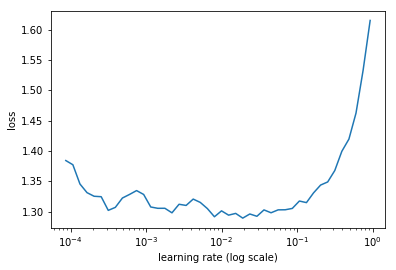

In [36]:
lrf = learn.lr_find()
learn.sched.plot()

In [35]:
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.385378   0.814995   0.774951  
    1      1.357629   0.794831   0.779843                 



[array([0.79483]), 0.7798434453934373]

In [ ]:
learn.save('aug_224')

In [ ]:
learn.load('aug_224')

## 3. Increase image size

* This trick needs a _fully convolutional_ architecture.
* It also performs a regularization of sorts, because the data structure changes.

In [37]:
learn.set_data(get_data(299, bs))
learn.freeze()  # Just to make sure its frozen (only updating the weights in the last layers).

 94%|█████████▍| 60/64 [03:33<00:14,  3.55s/it, loss=5.07]

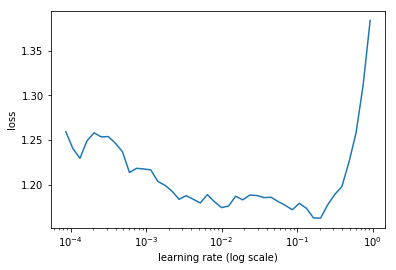

In [38]:
lrf = learn.lr_find()
learn.sched.plot()

In [39]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                 
    0      1.131914   0.427553   0.908023  
    1      1.046093   0.373002   0.90998                  
    2      0.948991   0.364028   0.913894                  
    3      0.897032   0.326136   0.91683                   
    4      0.810725   0.310241   0.911937                  
    5      0.781625   0.305208   0.911937                  
    6      0.759444   0.30379    0.914873                  


[array([0.30379]), 0.9148727976179403]

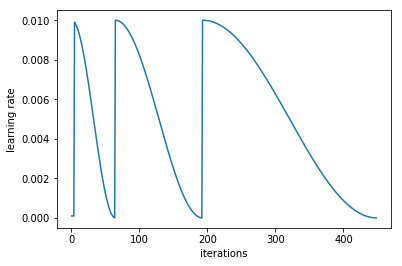

In [40]:
learn.sched.plot_lr()

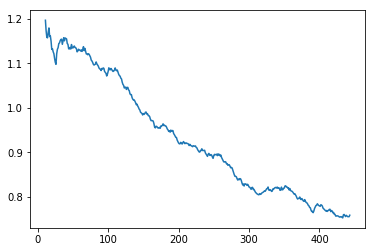

In [41]:
learn.sched.plot_loss()

In [ ]:
learn.save('model_299')

## 4. Predictions

* TO DO: `learn.TTA`
* TO DO: submit to Kaggle

In [81]:
log_preds, y = learn.TTA(is_test=False)  # Default, for validation set.
probs = np.exp(log_preds).mean(axis=0)
y_pred = probs.argmax(axis=1)

In [82]:
np.mean(y_pred == y)

0.9187866927592955

In [87]:
metrics.log_loss(y, probs), metrics.accuracy_score(y, y_pred)

(0.3115380834881561, 0.9187866927592955)

## 5. Submit to Kaggle

File format from Kaggle:

* TO DO

In [88]:
data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [89]:
data.test_ds.fnames

['test/28be661edf678a730dde4b41918f3dca.jpg',
 'test/5aa4280436034ebb01208a320ecda325.jpg',
 'test/ff71c0a7a71d994884c9f92457f0eda8.jpg',
 'test/0c6176b396e31ce7666185aa435be7e0.jpg',
 'test/2642aced641c09bd3252bb4014f0fe83.jpg',
 'test/1c857714795c657006755bf5e45613c9.jpg',
 'test/dc288ac53170b1659b3e9b1389e417cd.jpg',
 'test/d0abf32cdef48936e7c843311121ab0b.jpg',
 'test/59be845bcf901ac4139d9de6f4862686.jpg',
 'test/c0cfd9a2f6b1af1b1926ca9704c72227.jpg',
 'test/a9a33f0585e5af26dffd6dc0a00ba88f.jpg',
 'test/bb5dccafefdac840935697a0f648fd72.jpg',
 'test/5c31a03d1769fc7c8feec1da94845832.jpg',
 'test/2dbacd22574e6f6dbc22007491bdb752.jpg',
 'test/b7cb1a73a6512faf62c025ef9c4e6204.jpg',
 'test/2b560c80aaede000ebb101ffee26bf14.jpg',
 'test/c4e5a86214f9ac9b28c7381009b708ca.jpg',
 'test/430a0714247557573bdd9dabb2b02464.jpg',
 'test/0db3f774655ada5d6f78f2a3c31fd295.jpg',
 'test/a60e73d011dd220a692a1b885cad3508.jpg',
 'test/43a411e0747a0b39cbbed7802c5b6013.jpg',
 'test/a1cb7c5e21fcf06bcae959316c5

In [90]:
log_preds, y = learn.TTA(is_test=True)  # True for test set.
probs = np.exp(log_preds)

In [92]:
y_pred = probs.mean(axis=0).argmax(axis=1)
metrics.log_loss(y, probs.mean(axis=0)), accuracy(log_preds, y)

ValueError: y_true contains only one label (0.0). Please provide the true labels explicitly through the labels argument.

In [91]:
probs.shape

(5, 10357, 120)

In [97]:
df = pd.DataFrame(probs.mean(axis=0))
df.columns = data.classes
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,28be661edf678a730dde4b41918f3dca,0.000003,0.000070,0.000033,0.000039,0.000033,0.000004,0.000016,0.000012,0.001559,...,0.000006,0.000003,0.000456,0.000487,0.000027,0.000006,0.000002,0.000004,9.210171e-07,0.000006
1,5aa4280436034ebb01208a320ecda325,0.000131,0.000065,0.000022,0.000083,0.000012,0.000014,0.000056,0.000032,0.000032,...,0.453028,0.000419,0.000023,0.000015,0.000029,0.000018,0.000064,0.000018,3.456547e-04,0.000934
2,ff71c0a7a71d994884c9f92457f0eda8,0.000616,0.000458,0.000209,0.000067,0.000530,0.000964,0.000792,0.000829,0.000860,...,0.000336,0.000589,0.000513,0.003989,0.000366,0.008688,0.001152,0.001750,2.973735e-04,0.000938
3,0c6176b396e31ce7666185aa435be7e0,0.001149,0.000454,0.000072,0.000353,0.000011,0.000017,0.000008,0.000007,0.000004,...,0.000206,0.000002,0.000009,0.000002,0.000008,0.000007,0.000105,0.000005,4.170425e-05,0.000030
4,2642aced641c09bd3252bb4014f0fe83,0.000033,0.000044,0.000034,0.000071,0.000039,0.000080,0.000060,0.000039,0.015905,...,0.000079,0.000038,0.000120,0.001998,0.000102,0.829634,0.000017,0.000058,2.120030e-04,0.000146


In [98]:
SUBM = PATH + 'subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(SUBM + 'subm.gz')
FileLink(SUBM + 'subm.gz')  # To download from server :)

/home/ubuntu/fastai-notes/data/dog-breed-identification/subm/subm.gz

## Predicting one observation

In [ ]:
j = 100
fn = data.test_ds.fnames[j]
trn_tfms, val_tfms = tfms_from_model(arch, sz)  # Actually returns a tupple
im = val_tfms(Image.open(PATH + fn))
preds = learn.predict_array(im[None])  
# [None] to add additional dimension. That is, to specify that it is not a minibatch.

np.argmax(preds)